In [1]:
%env OMP_NUM_THREADS=1
import firedrake as fd
import numpy as np
from scipy.special import hankel1
import matplotlib.pyplot as plt

env: OMP_NUM_THREADS=1


In [2]:
omega = 750
c = 340
k = omega / c
a0 = b0 = 2.0
a1 = b1 = 2.25
x0 = np.array([0.5, 0])

In [3]:
def plot_mesh(m):
    fig, axes = plt.subplots()
    interior_kw = {"linewidths": 0.2}
    fd.triplot(m, axes=axes, interior_kw=interior_kw)
    axes.set_aspect("equal")
    axes.legend()

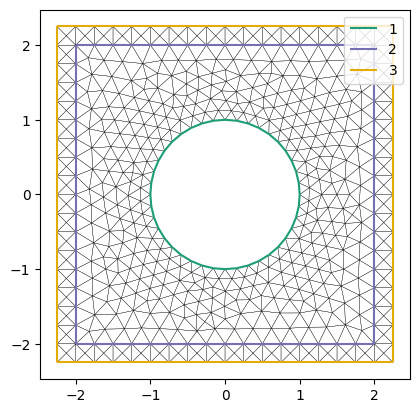

In [4]:
mesh = fd.Mesh("mesh.msh")
plot_mesh(mesh)

mesh = fd.MeshHierarchy(mesh, 3)[-1]
W = fd.VectorFunctionSpace(mesh, "CG", 1)

p = fd.TrialFunction(W)
q = fd.TestFunction(W)

s = fd.Function(W)
exact = fd.Function(W)
g = fd.Function(W)

In [5]:
def assign_data(v, v_data):
    v.sub(0).dat.data[:] = v_data.real
    v.sub(1).dat.data[:] = v_data.imag

def prod2(x, y):
    x_re, x_im = x
    y_re, y_im = y
    res_re = x_re * y_re - x_im * y_im
    res_im = x_re * y_im + x_im * y_re
    return res_re + res_im

def prod3(x, y, z):
    x_re, x_im = x[0], x[1]
    y_re, y_im = y[0], y[1]
    z_re, z_im = z[0], z[1]
    res_re = x_re * y_re * z_re - x_re * y_im * z_im - x_im * y_re * z_im - x_im * y_im * z_re
    res_im = x_re * y_re * z_im + x_re * y_im * z_re + x_im * y_re * z_re - x_im * y_im * z_im
    return res_re + res_im

In [6]:
X_data = fd.interpolate(mesh.coordinates, W).dat.data_ro

dist = np.linalg.norm(X_data - x0, axis=1)

exact_data = 1j / 4 * hankel1(0, k * dist)
assign_data(exact, exact_data)

# Neumann boundary condition
g_data = -1j / 4 * hankel1(1, k * dist) \
         * k / dist * np.einsum("ij,ij->i", X_data - x0, -X_data)
assign_data(g, g_data)

In [7]:
X = fd.SpatialCoordinate(mesh)

sigma_x = 1 / k / (a1 - abs(X[0]))
sigma_y = 1 / k / (b1 - abs(X[1]))

c1x = (1 / (1 + sigma_x**2),
       -sigma_x / (1 + sigma_x**2))
c2x = (1, sigma_x)
c3x = (1, sigma_x)

c1y = (1, sigma_y)
c2y = (1 / (1 + sigma_y**2),
       -sigma_y / (1 + sigma_y**2))
c3y = (1, sigma_y)

c1xy = ((1 + sigma_x * sigma_y) / (1 + sigma_x**2),
        (sigma_y - sigma_x) / (1 + sigma_x**2))
c2xy = ((1 + sigma_x * sigma_y) / (1 + sigma_y**2),
        (sigma_x - sigma_y) / (1 + sigma_y**2))
c3xy = (1 - sigma_x * sigma_y, sigma_x + sigma_y)

In [8]:
px, py = p.dx(0), p.dx(1)
qx, qy = q.dx(0), q.dx(1)

a = (prod2(px, qx) + prod2(py, qy) - k**2 * prod2(p, q)) * fd.dx(1) \
    + (prod3(c1x, px, qx) + prod3(c2x, py, qy) - k**2 * prod3(c3x, p, q)) * fd.dx(2) \
    + (prod3(c1y, px, qx) + prod3(c2y, py, qy) - k**2 * prod3(c3y, p, q)) * fd.dx(3) \
    + (prod3(c1xy, px, qx) + prod3(c2xy, py, qy) - k**2 * prod3(c3xy, p, q)) * fd.dx(4)
L = (prod2(g, q)) * fd.ds(1)
# L = fd.Constant(0) * q[0] * fd.dx

bcs = [fd.DirichletBC(W, (0., 0), 3), fd.DirichletBC(W.sub(1), 0., 3)]
# bcs = [fd.DirichletBC(W, exact, 1),  fd.DirichletBC(W, (0., 0.), 3)]
fd.solve(a == L, s, bcs=bcs)

In [9]:
def plot_field(u):
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)

    plot1 = fd.tripcolor(u.sub(0), axes=ax1)
    ax1.set_aspect("equal")
    ax1.set_title("Real part")
    ax1.set_xlim(-a1, a1)
    ax1.set_ylim(-b1, b1)
    ax1.add_patch(
        plt.Rectangle((-a0, -b0), 2*a0, 2*b0, color='w', fill=False))
    fig.colorbar(plot1, shrink=0.5, ax=ax1)
    
    plot2 = fd.tripcolor(u.sub(1), axes=ax2)
    ax2.set_aspect("equal")
    ax2.set_title("Imaginary part")
    ax2.set_xlim(-a1, a1)
    ax2.set_ylim(-b1, b1)
    ax2.add_patch(
        plt.Rectangle((-a0, -b0), 2*a0, 2*b0, color='w', fill=False))
    fig.colorbar(plot2, shrink=0.5, ax=ax2)

Exact solution:


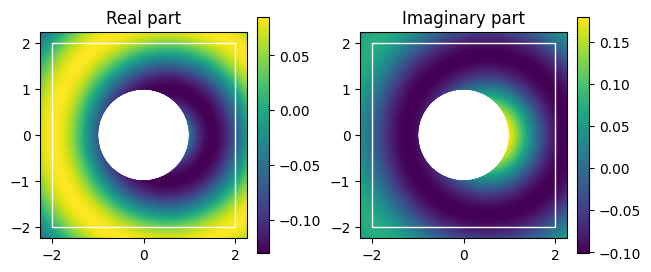

In [10]:
print("Exact solution:")
plot_field(exact)

Numerical solution:


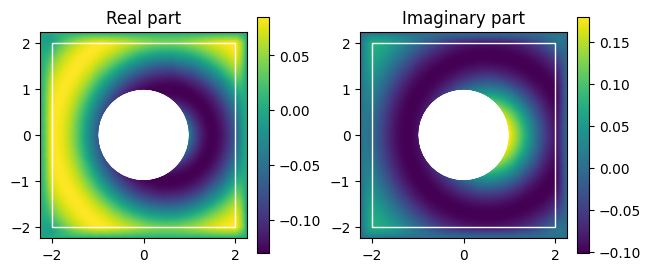

In [11]:
print("Numerical solution:")
plot_field(s)

In [12]:
def compute_error(u, uh, relative=True):
    v = u - uh
    err = fd.assemble(fd.inner(v, v) * fd.dx(1))**0.5
    if relative:
        err /= fd.assemble(fd.inner(u, u) * fd.dx(1))**0.5
    return err

In [13]:
rel_err = compute_error(exact, s)
print(f"Relative error is {rel_err:.2%}")

Relative error is 0.26%
